In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression


import sys
import os

import sys
import os
sys.path.append(os.path.abspath("../../.."))

from Preprocessing.imputation import get_imputation_maps, apply_imputation, ContextImputer

from Preprocessing.split_new import split_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction

Linear Regression Performance Metrics:
MAE: 4070.54
MAPE: 16.96
RMSE: 32493.47
R²: 0.49
------------------------------


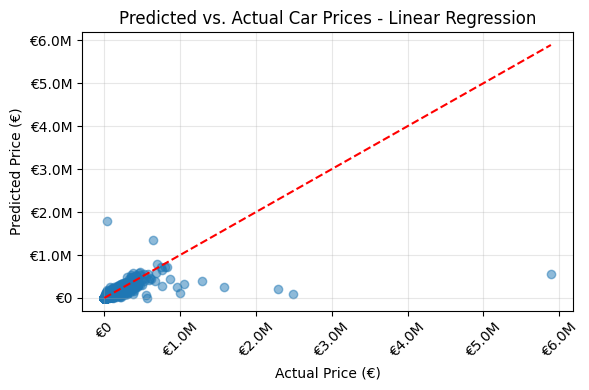

In [2]:
def main():


    X_train, X_test, y_train, y_test, categorical_features , numeric_features = split_data('../../../data.csv', segment = True)

    # Preprocessing-Pipelines erstellen
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    transformed_model = TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log1p,
        inverse_func=np.expm1
    )


    linear_regression_pipeline = Pipeline(steps=[
        ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
        ('imp_ps', ContextImputer('power_ps')),
        ('imp_er', ContextImputer('electric_range')),
        ('preprocessor', preprocessor),
        ('model', transformed_model)
    ])

    # Modell trainieren
    linear_regression_pipeline.fit(X_train, y_train)

    # Vorhersagen treffen
    y_pred_lr = linear_regression_pipeline.predict(X_test)



    evaluate_model(y_test, y_pred_lr, "Linear Regression")

    scatter_prediction(y_test, y_pred_lr, "Linear Regression")
    
    # Prüfe, ob fuel_type in X_test enthalten ist
    if 'fuel_type' in X_test.columns:
        results_df = pd.DataFrame({
            'fuel_type': X_test['fuel_type'].values,
            'y_true': y_test.values,
            'y_pred': y_pred_lr
        })

        from sklearn.metrics import mean_absolute_error, mean_squared_error

        #print("\nFehleranalyse nach Fuel Type:")
        for fuel in results_df['fuel_type'].unique():
            subset = results_df[results_df['fuel_type'] == fuel]
            mae = mean_absolute_error(subset['y_true'], subset['y_pred'])
         #
         #    print(f"{fuel:10s} – MAE: {mae:.2f}, N = {len(subset)}")



if __name__ == "__main__":
    main()